In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from fastai.vision.all import *

In [62]:
train_path = Path('/kaggle/input/food-recognition/public_training_set_release_2.1')
annotations_path = train_path / 'annotations.json'
imgs, lbl_bbox = get_annotations(annotations_path)

In [63]:
imgs[0], lbl_bbox[0]

('131072.jpg',
 ([[61.5, 61.5, 379.5, 383.5],
   [93.82462890625001,
    93.82462890625001,
    368.37733215332037,
    366.42462890625006]],
  ['bread_wholemeal', 'jam']))

In [64]:
img2bbox = dict(zip(imgs,lbl_bbox))

In [65]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'131072.jpg': ([[61.5, 61.5, 379.5, 383.5],
   [93.82462890625001,
    93.82462890625001,
    368.37733215332037,
    366.42462890625006]],
  ['bread_wholemeal', 'jam'])}

In [66]:
getters = [lambda o: train_path/'images'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

In [67]:
item_tfms = [Resize(224, method='squish'),]
batch_tfms = [Rotate(), Flip(), Dihedral()]

In [68]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                  splitter=RandomSplitter(),
                  getters=getters,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms,
                  n_inp=1)

In [69]:
dls = pascal.dataloaders(imgs, bs=128)

In [70]:
dls.vocab

['#na#', 'alfa_sprouts', 'almonds', 'aperitif_with_alcohol_n_s_aperol_spritz', 'apple', 'apple_pie', 'applesauce', 'apricots', 'artichoke', 'asparagus', 'aubergine_eggplant', 'avocado', 'bacon', 'baked_potato', 'balsamic_salad_dressing', 'banana', 'banana_cake', 'basil', 'beans_kidney', 'beef_n_s', 'beer', 'beetroot-steamed-without-addition-of-salt', 'beetroot_raw', 'bell_pepper_red_raw', 'bell_pepper_red_stewed', 'berries_n_s', 'birchermuesli_prepared_no_sugar_added', 'biscuit', 'black_olives', 'blue_mould_cheese', 'blueberries', 'bolognaise_sauce', 'bouillon', 'braided_white_loaf_ch', 'bread', 'bread_black', 'bread_fruit', 'bread_grain', 'bread_pita', 'bread_rye', 'bread_ticino_ch', 'bread_toast', 'bread_white', 'bread_whole_wheat', 'bread_wholemeal', 'bread_wholemeal_toast', 'breadcrumbs_unspiced', 'brioche', 'broccoli', 'brownie', 'brussel_sprouts', 'bulgur', 'butter', 'butter_spread_puree_almond', 'cake_chocolate', 'cake_lemon', 'capers', 'cappuccino', 'caprese_salad_tomato_mozzar

In [71]:
len(dls.vocab)

324

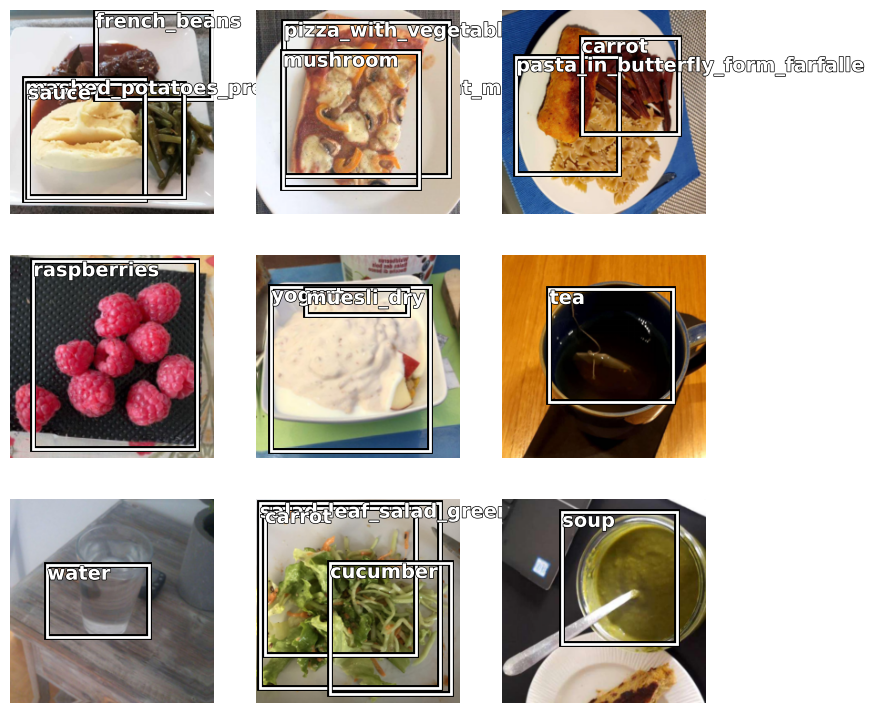

In [72]:
dls.show_batch()

In [73]:
one_batch = dls.one_batch()

In [74]:
one_batch[1][0][0]

TensorBBox([-0.5150, -0.7025,  0.7025,  0.1775], device='cuda:0')

In [75]:
one_batch[2]

TensorMultiCategory([[300, 262, 245,  ...,   0,   0,   0],
                     [ 42,   0,   0,  ...,   0,   0,   0],
                     [298,   0,   0,  ...,   0,   0,   0],
                     ...,
                     [ 48, 269,   0,  ...,   0,   0,   0],
                     [320,   0,   0,  ...,   0,   0,   0],
                     [301, 118, 255,  ...,   0,   0,   0]], device='cuda:0')

In [76]:
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [77]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(dls.vocab))*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
               flatten_conv(self.oconv2(x), self.k)]

In [78]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [79]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
    
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)

In [80]:
k=1

In [81]:
head_reg4 = SSD_Head(k, -3)

In [82]:
body = create_body(resnet34(True))
model = nn.Sequential(body, head_reg4)

In [83]:
out0 = body(one_batch[0].cpu())

In [84]:
out1 = head_reg4(out0)

In [85]:
out1[0].shape, out1[1].shape

(torch.Size([128, 16, 324]), torch.Size([128, 16, 4]))

In [86]:
import numpy as np
import torch

anc_grid = 4
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid) 
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_ctrs = np.stack([anc_x, anc_y], axis=1)
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for _ in range(anc_grid*anc_grid)])

top_left_x = anc_ctrs[:, 0] - 0.5 * anc_sizes[:, 0]
top_left_y = anc_ctrs[:, 1] - 0.5 * anc_sizes[:, 1]

coco_anchors = torch.tensor(np.stack([top_left_x, top_left_y, anc_sizes[:, 0], anc_sizes[:, 1]], axis=1), requires_grad=False).cuda()


In [87]:
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects

In [88]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

In [89]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [90]:
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [91]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [92]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [93]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

In [94]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [95]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    k=0
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>1) and (pr is None or pr > thresh)):
            k+=1
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{k}: '
            if c is not None: txt += ('bg' if c==0 else dls.vocab[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [96]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

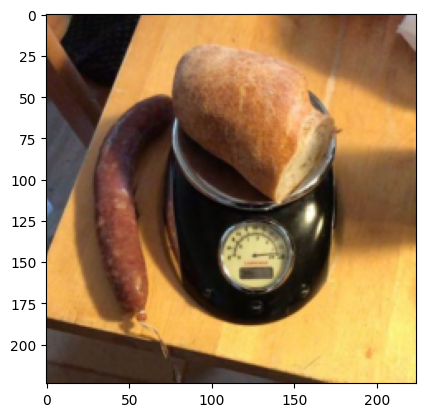

In [97]:
idx = 5
img = one_batch[0][idx].permute(2,1,0).cpu()
plt.imshow(img)

In [98]:
x = one_batch[0].permute(0,3,2,1).cpu()
y = one_batch[1:]

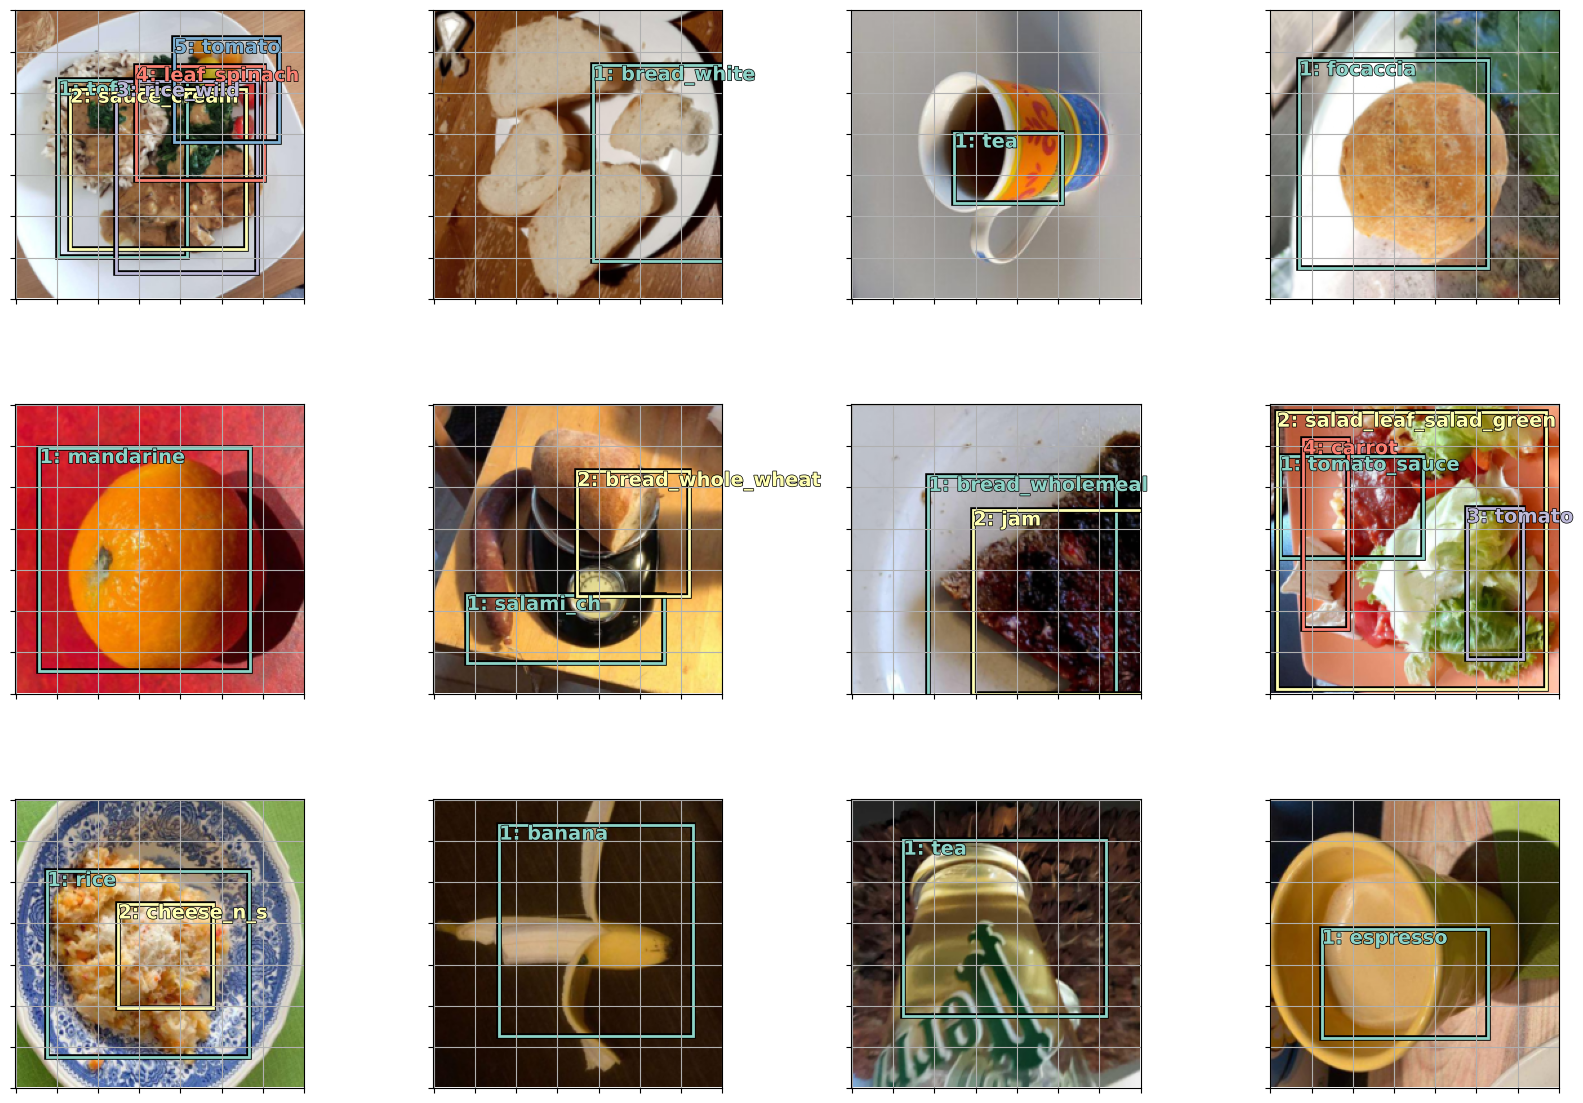

In [99]:
fig, axes = plt.subplots(3, 4, figsize=(16,12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i].cpu(), ((y[0][i]+1)/2*224).cpu(), y[1][i].cpu())
plt.tight_layout()

In [100]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)
    clas = clas.view(-1,1)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return TensorBase(bbox)[bb_keep],TensorBase(clas)[bb_keep]

In [101]:
one_batch[2][idx]

TensorMultiCategory([256,  43,   0,   0,   0,   0,   0,   0,   0],
                    device='cuda:0')

In [102]:
get_y(one_batch[1][idx], one_batch[2][idx])

(TensorBBox([[ 0.3175, -0.7725,  0.7825,  0.5850],
             [-0.5418, -0.0063,  0.3117,  0.7594]], device='cuda:0'),
 TensorBBox([[256],
             [ 43]], device='cuda:0'))

In [103]:
def hw2corners(ctr, hw):
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [104]:
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [126]:
def one_hot_embedding(labels, num_classes):
    device = labels.device  # Get the device from the labels tensor
    return torch.eye(num_classes, device=device)[labels]  # Ensure the one-hot matrix is on the same device

In [127]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

In [128]:
def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

In [129]:
def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [162]:
def map_to_ground_truth(overlaps):
    if overlaps.size(0) == 0 or overlaps.size(1) == 0:
        print("Warning: No overlaps found")
        # Handle the case appropriately, perhaps by returning dummy values or skipping
        return torch.tensor([]), torch.tensor([])
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i, o in enumerate(prior_idx):
        gt_idx[o] = i
    return gt_overlap, gt_idx.long()

In [163]:
def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    bbox = (bbox+1)/2
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap, gt_idx = map_to_ground_truth(overlaps)
    gt_idx = gt_idx.long() 
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0  # Assign the background to idx 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((TensorBase(a_ic[TensorBase(pos_idx)]) - TensorBase(gt_bbox[TensorBase(pos_idx)])).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [164]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:]).cuda()

In [165]:
idx = 0
bbox = one_batch[1][idx].cuda()
clas = one_batch[2][idx].cuda()

In [166]:
bbox,clas = get_y(bbox,clas)
bbox = (bbox+1)/2
# a_ic = actn_to_bb(b_bb, anchors)
overlaps = jaccard(bbox.data, anchor_cnr.data)
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_clas = clas[gt_idx]
pos = gt_overlap > 0.4
pos_idx = torch.nonzero(pos)[:,0]
gt_clas[~pos] = 0  # Assign the background to idx 0
gt_bbox = bbox[gt_idx]

In [167]:
ima = one_batch[0][idx].permute(2,1,0).cpu()

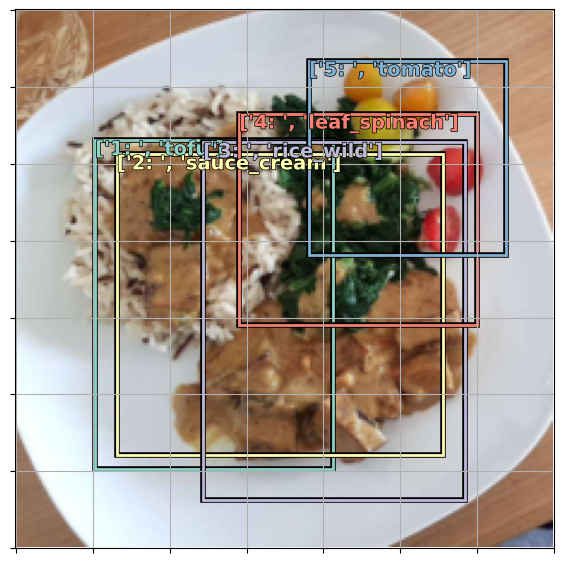

In [168]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

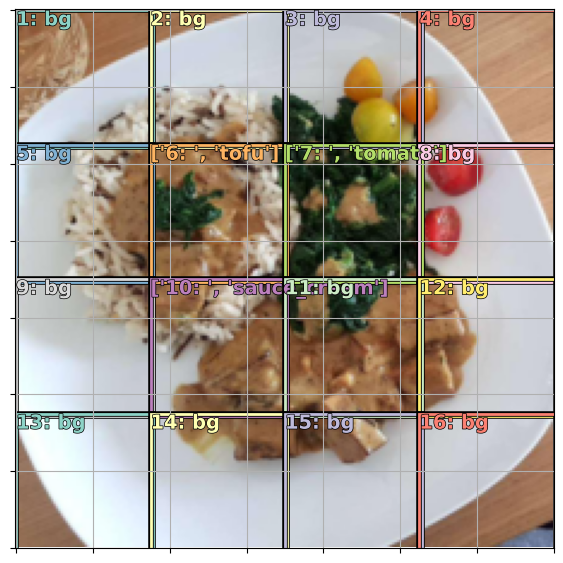

In [169]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, gt_clas)

In [170]:
sz = 224

In [171]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ.squeeze(), self.num_classes)
        t = t[:,1:] # Start from 1 to exclude the Background
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w.detach(), reduction='sum')/self.num_classes
    
    def get_weight(self,x,t): return None

In [172]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [173]:
def ssd_loss(pred, bbox, clas):
    lcs, lls = 0., 0.
    W = 30
    for b_c, b_bb, bbox, clas in zip(*pred, bbox, clas):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas)
        lls += loc_loss
        lcs += clas_loss
    return lls + lcs

In [174]:
loss_f = FocalLoss(len(dls.vocab))

In [175]:
model = nn.Sequential(body, head_reg4)

In [176]:
learner = Learner(dls, model, loss_func=ssd_loss)

In [177]:
learner.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time


RuntimeError: The size of tensor a (16) must match the size of tensor b (0) at non-singleton dimension 0